In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
# Set seed for reproducibility
np.random.seed(42)

# Define Mess3 HMM parameters
states = ['S0', 'S1', 'S2']
observations = ['A', 'B', 'C']

# Transition probability matrix (states x states)
# Rows: from state, Columns: to state
transition_matrix = np.array([
    [0.7, 0.15, 0.15],  # From S0
    [0.15, 0.7, 0.15],  # From S1
    [0.15, 0.15, 0.7]   # From S2
])

# Emission probability matrix (states x observations)
# Rows: state, Columns: observation
emission_matrix = np.array([
    [0.6, 0.2, 0.2],  # S0 emits mostly A
    [0.2, 0.6, 0.2],  # S1 emits mostly B
    [0.2, 0.2, 0.6]   # S2 emits mostly C
])

In [2]:
initial_state_dist = np.array([0.5, 0.3, 0.2])

def sample_hmm_sequence(n_steps):
    hidden_states = []
    observations_seq = []

    # Initial state
    current_state = np.random.choice(len(states), p=initial_state_dist)
    for _ in range(n_steps):
        hidden_states.append(states[current_state])
        obs = np.random.choice(observations, p=emission_matrix[current_state])
        observations_seq.append(obs)
        current_state = np.random.choice(len(states), p=transition_matrix[current_state])
    
    return hidden_states, observations_seq

In [3]:
n_samples = 150000
hidden_seq, obs_seq = sample_hmm_sequence(n_samples)

df = pd.DataFrame({
    'hidden_state': hidden_seq,
    'observation': obs_seq
})

In [4]:
def obs_update(prior, observation_index):
    new_dist = []
    for state_index in range(len(prior)):
        new_dist.append(emission_matrix[state_index][observation_index] * prior[state_index])
    
    return new_dist / sum(new_dist)

def step_update(prior):
    new_dist = []
    for state_index in range(len(prior)):
        new_dist.append(sum([transition_matrix[list(prior).index(prev_state)][state_index] * prev_state for prev_state in prior]))
    return new_dist/sum(new_dist)

In [5]:
p = np.array([1/3, 1/3, 1/3])
belief_states = []
steps = 10000
n_steps = 15
for step in trange(steps):
    
    for _ in range(n_steps):
        state, obs = df.iloc[step*_]
        state_index = states.index(state)
        obs_index = observations.index(obs)
        p = obs_update(p, obs_index)
        p = step_update(p)    
    belief_states.append(p)

100%|██████████| 10000/10000 [00:05<00:00, 1786.70it/s]


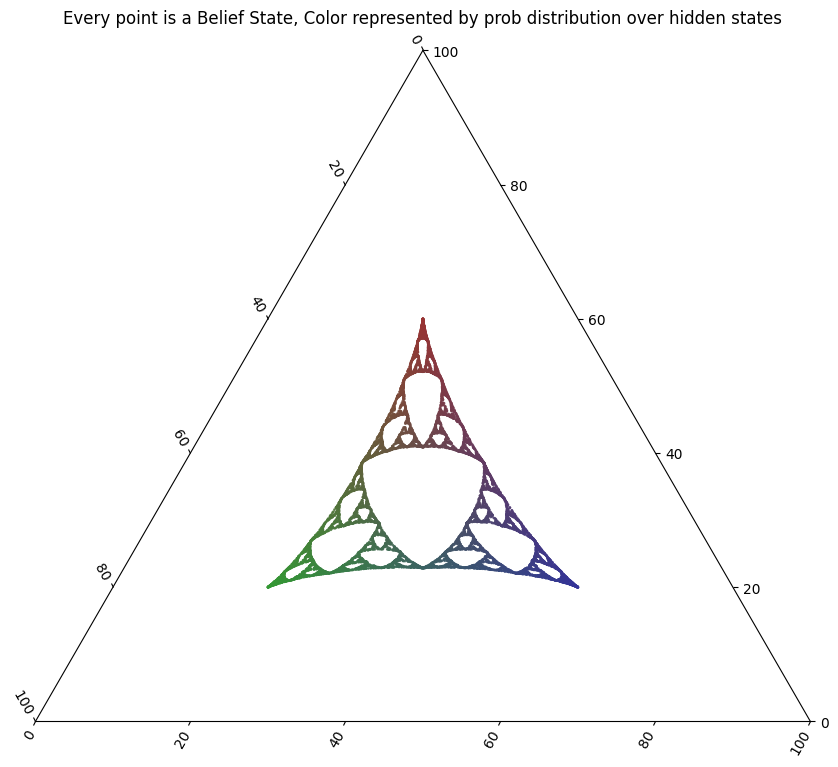

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mpltern

beliefs = np.stack(belief_states)
# Use the beliefs directly as RGB colors
colors = beliefs  # Each row is (R, G, B)

# Plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection="ternary", ternary_sum=100.0, )
ax.scatter(beliefs[:, 0], beliefs[:, 1], beliefs[:, 2], alpha = 0.8, c = colors, s=1)
plt.title("Every point is a Belief State, Color represented by prob distribution over hidden states")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# ---- Config ----
SEQ_LEN = 10
BATCH_SIZE = 64
EMBED_DIM = 256
NUM_HEADS = 1
NUM_LAYERS = 4
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---- Load and preprocess data ----
obs_vocab = sorted(df['observation'].unique())  # ['A', 'B', 'C']
obs2idx = {o: i for i, o in enumerate(obs_vocab)}
idx2obs = {i: o for o, i in obs2idx.items()}
vocab_size = len(obs_vocab)

# Encode observations
encoded_obs = df['observation'].map(obs2idx).values

In [9]:
# ---- Dataset ----
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.xs = []
        self.ys = []
        for i in range(len(data) - seq_len):
            self.xs.append(torch.tensor(data[i:i+seq_len], dtype=torch.long))
            self.ys.append(torch.tensor(data[i+1:i+seq_len+1], dtype=torch.long))

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

dataset = SequenceDataset(encoded_obs, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [10]:
# ---- Transformer Model ----
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, seq_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.token_embedding(x) + self.pos_embedding
        x = self.transformer(x)
        return self.fc_out(x)

model = SimpleTransformer(vocab_size, EMBED_DIM, NUM_HEADS, NUM_LAYERS, SEQ_LEN).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()



/Users/shreyansjain/.pyenv/versions/3.10.14/envs/arena_exercise/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
# ---- Training Loop ----
for epoch in trange(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)  # (batch, seq_len, vocab)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: loss = {total_loss / len(dataloader):.4f}")


 10%|█         | 1/10 [04:34<41:09, 274.37s/it]

Epoch 1: loss = 0.1536


 20%|██        | 2/10 [09:13<36:56, 277.12s/it]

Epoch 2: loss = 0.1764


 30%|███       | 3/10 [14:31<34:31, 295.86s/it]

Epoch 3: loss = 1.0210


 40%|████      | 4/10 [20:28<31:59, 319.93s/it]

Epoch 4: loss = 0.6276


 40%|████      | 4/10 [47:38<1:11:27, 714.58s/it]


KeyboardInterrupt: 